
# Lab8: Optical Flow: Predicting movement with the RAFT model

Optical flow is the task of predicting movement between two images, usually two
consecutive frames of a video. Optical flow models take two images as input, and
predict a flow: the flow indicates the displacement of every single pixel in the
first image, and maps it to its corresponding pixel in the second image. Flows
are (2, H, W)-dimensional tensors, where the first axis corresponds to the
predicted horizontal and vertical displacements.

The following example illustrates how torchvision can be used to predict flows
using our implementation of the RAFT model. We will also see how to convert the
predicted flows to RGB images for visualization.


In [95]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if img.dtype == torch.uint8:
                print('flow')
                img = F.to_pil_image((img).to("cpu"))
            else: #torch.float32
                print('RGB')
                img = F.to_pil_image(unorm(img).to("cpu"))
                
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

## Reading Videos Using Torchvision
We will first read a video using :func:`~torchvision.io.read_video`.
Alternatively one can use the new :class:`~torchvision.io.VideoReader` API (if
torchvision is built from source).

In [96]:
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchvision

image_folder = r'path_to_images'

class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.depth_files = [f for f in os.listdir(root_dir) if f.endswith('.depth.exr.tiff')]
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.depth_files)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.root_dir, self.depth_files[idx])
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])

        depth_image = T.ToTensor()(np.array(Image.open(depth_path)))
        rgb_image = torchvision.io.read_image(rgb_path)

        if self.transform:
            depth_image = self.transform(depth_image)
            rgb_image = self.transform(rgb_image)

        return rgb_image, depth_image

transform = T.Compose(
    [
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
    ]
)


dataset = DepthDataset(image_folder, transform)
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        if tensor.dim == 4:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        else:
            tensor.mul_(self.std).add_(self.mean)
        return tensor
unorm = UnNormalize(mean=(0.5), std=(0.5))

rgb1, depth = dataset[100]
rgb_un1 = unorm(rgb1).permute((1,2,0))

rgb2, depth = dataset[102]
rgb_un2 = unorm(rgb2).permute((1,2,0))

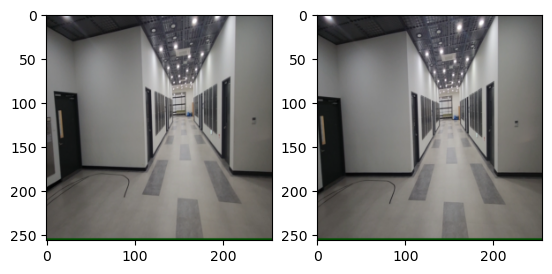

In [97]:
plt.subplot(1,2,1); plt.imshow(rgb_un1)
plt.subplot(1,2,2); plt.imshow(rgb_un2)

0 torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])
1 torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])
2 torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])
RGB
RGB
RGB
RGB


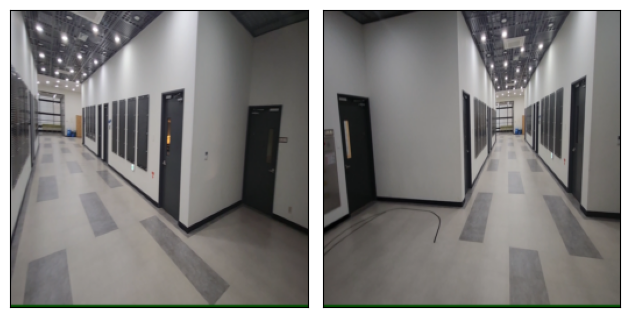

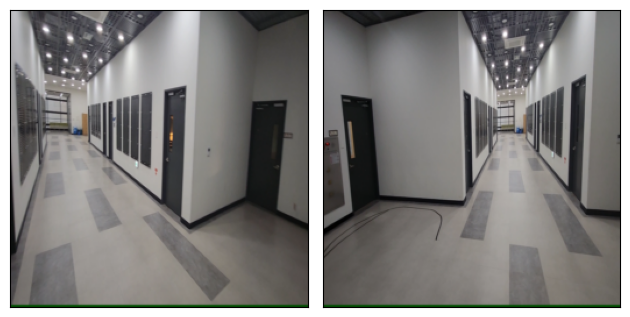

In [98]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

for cnt, (imgs, rgbs) in enumerate(dataloader):
    print(cnt, imgs.shape, rgbs.shape)
    if cnt >= 2:
        break

img1_batch = imgs[[0,-2]]
img2_batch = imgs[[2,-1]]

plot(img1_batch)
plot(img2_batch)

The RAFT model that we will use accepts RGB float images with pixel values in
[-1, 1]. The frames we got from :func:`~torchvision.io.read_image` are int
images with values in [0, 255], so we will have to pre-process them. We also
reduce the image sizes for the example to run faster. Image dimension must be
divisible by 8.

In [99]:
# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = img1_batch.to(device)
img2_batch = img2_batch.to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 256, 256]), dtype = torch.float32


## Estimating Optical flow using RAFT
We will use our RAFT implementation from
:func:`~torchvision.models.optical_flow.raft_large`, which follows the same
architecture as the one described in the `original paper <https://arxiv.org/abs/2003.12039>`_.
We also provide the :func:`~torchvision.models.optical_flow.raft_small` model
builder, which is smaller and faster to run, sacrificing a bit of accuracy.



In [106]:
from torchvision.models.optical_flow import raft_large

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

C:\Users\Sim\anaconda3\envs\pose_regress_2024\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Sim\anaconda3\envs\pose_regress_2024\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


type = <class 'list'>
length = 12 = number of iterations of the model


The RAFT model outputs lists of predicted flows where each entry is a
(N, 2, H, W) batch of predicted flows that corresponds to a given "iteration"
in the model. For more details on the iterative nature of the model, please
refer to the `original paper <https://arxiv.org/abs/2003.12039>`_. Here, we
are only interested in the final predicted flows (they are the most acccurate
ones), so we will just retrieve the last item in the list.

As described above, a flow is a tensor with dimensions (2, H, W) (or (N, 2, H,
W) for batches of flows) where each entry corresponds to the horizontal and
vertical displacement of each pixel from the first image to the second image.
Note that the predicted flows are in "pixel" unit, they are not normalized
w.r.t. the dimensions of the images.



In [107]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 256, 256]) = (N, 2, H, W)
min = -7.8778181076049805, max = 7.159621238708496


## Visualizing predicted flows
Torchvision provides the :func:`~torchvision.utils.flow_to_image` utlity to
convert a flow into an RGB image. It also supports batches of flows.
each "direction" in the flow will be mapped to a given RGB color. In the
images below, pixels with similar colors are assumed by the model to be moving
in similar directions. The model is properly able to predict the movement of
the ball and the player. Note in particular the different predicted direction
of the ball in the first image (going to the left) and in the second image
(going up).



In [108]:
flow_imgs.dtype, img1_batch[0].dtype, flow_imgs.shape, img1_batch[0].shape

(torch.uint8,
 torch.float32,
 torch.Size([2, 3, 256, 256]),
 torch.Size([3, 256, 256]))

RGB
flow
RGB
flow


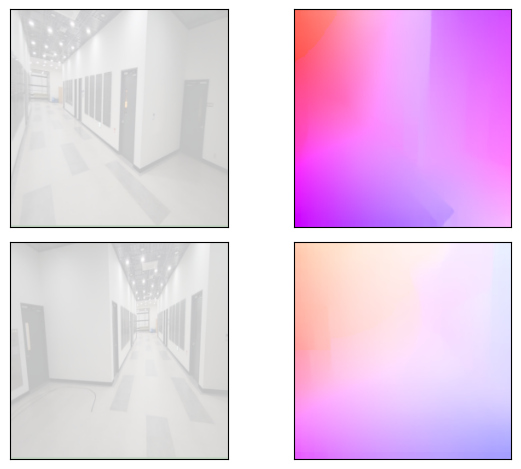

In [109]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (2, 256, 256)
(256,) (256,)
(256, 256, 3) (2, 256, 256)
(256,) (256,)


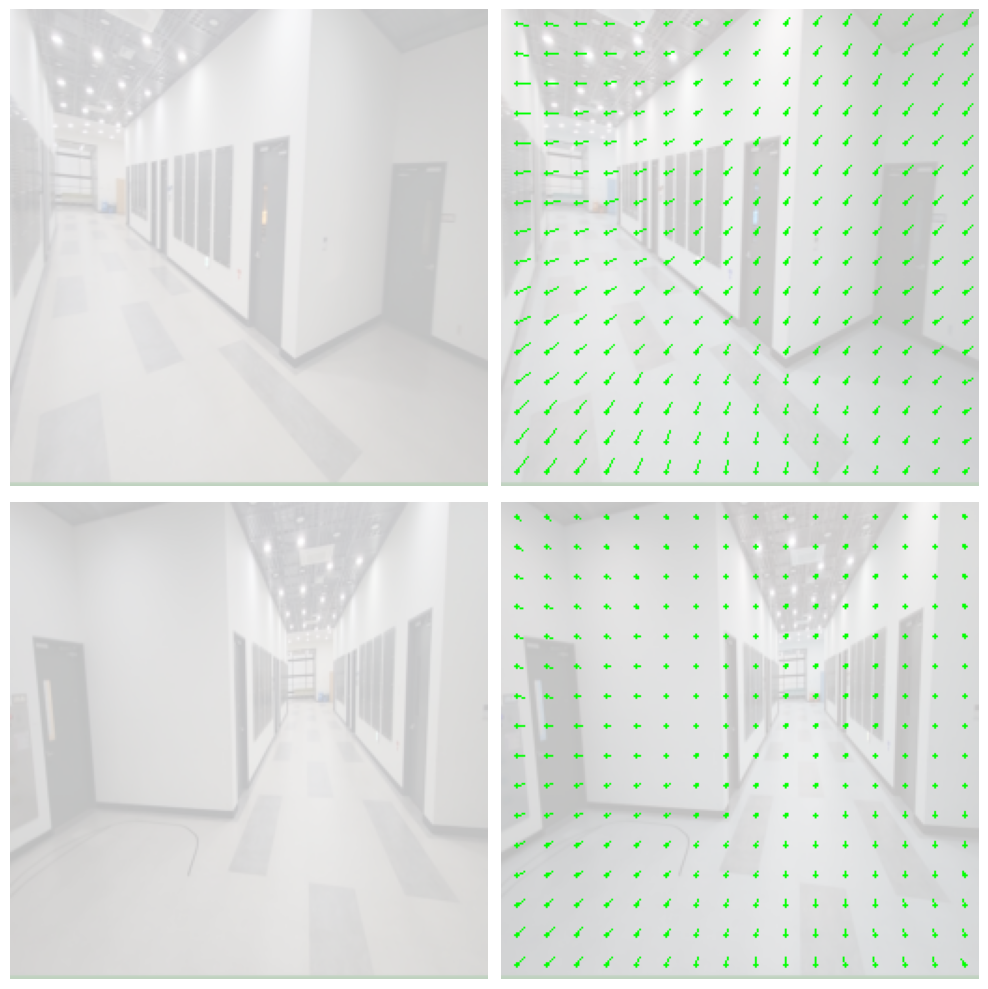

In [123]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import flow_to_image

def draw_flow(img, flow, step=16):
    """Draws optical flow arrows on the image."""
    print(img.shape, flow.shape)
    # flow = flow.permute((1,2,0))
    flow = flow.transpose((1,2,0))
    h, w = img.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    # print(x, y)
    fx, fy = flow[y, x].T
    
    # Create a mask that will be used for drawing
    print(x.shape, fx.shape)
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    # print(img.shape)
    vis = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # vis = np.array(img)
    
    # Draw the lines on the image
    cv2.polylines(vis, lines, isClosed=False, color=(0, 255, 0))
    
    # Draw the endpoints of the flow vectors
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# Assuming predicted_flows is a batch of flow vectors and img1_batch is a batch of images
flow_imgs = flow_to_image(predicted_flows)  # Convert flow vectors to images

predicted_flows_np = predicted_flows.cpu().detach().numpy()
# Draw optical flow on images
flow_visualizations = [draw_flow(img1.numpy().transpose(1, 2, 0), flow_img) for img1, flow_img in zip(img1_batch, predicted_flows_np)]

# Setup for plotting
fig, axs = plt.subplots(len(flow_visualizations), 2, figsize=(10, len(flow_visualizations) * 5))

for i, (img, flow_viz) in enumerate(zip(img1_batch, flow_visualizations)):
    axs[i, 0].imshow(img.permute((1,2,0)), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(flow_viz)
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()
